# Bridge Matching

## Import

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "../src/")
from BM import MLP, SDE_Solver, train_velocity, sample_2d_gaussian, sample_2d_swiss_roll
%matplotlib inline

## Global Params

In [2]:
#======
#Device params
DEVICE = "cuda"
#SEED = 2024
#torch.manual_seed(SEED); np.random.seed(SEED)

#=====
#Data params
STD = 0.5 #Swiss Roll std (manages the "tightness")
DATA_N = 1000 #number of points to be plotted and mapped 

#=====
#Neural network params
LAYER_LIST = [3, 256, 512, 1024, 512, 256, 2]
L_R = 1e-3
EPOCHES = 30000
BATCH_SIZE = 128

#======
#SDE params
EPS = 0.05 #Epsilon or variance for SDE
STEPS = 1000 #Steps for time discretization in Euler-Maruyama method

## Velocity/Drift model Training

$V_{\theta}(x,t): \mathbb{R}^{n+1} \to \mathbb{R}^{n}$ - velocity or drift, since we sample an object with two coordinates $(x, y)$, hence $\mathbb{n = 2}$

In [3]:
#=====
#Define Network
velocity_net = MLP(layer_list=LAYER_LIST).to(DEVICE)
velocity_net.reset_parameters()

#=====
#Train Network
loss_arr = train_velocity(velocity_net, to_swiss_roll=True, batch_size=BATCH_SIZE,epoches=EPOCHES, eps=EPS, std=STD, l_r=L_R, device=DEVICE)

Vnet params: 1314562


100%|██████████| 30000/30000 [00:40<00:00, 737.26it/s]


## Plot Results

### "Freshly" Trained net

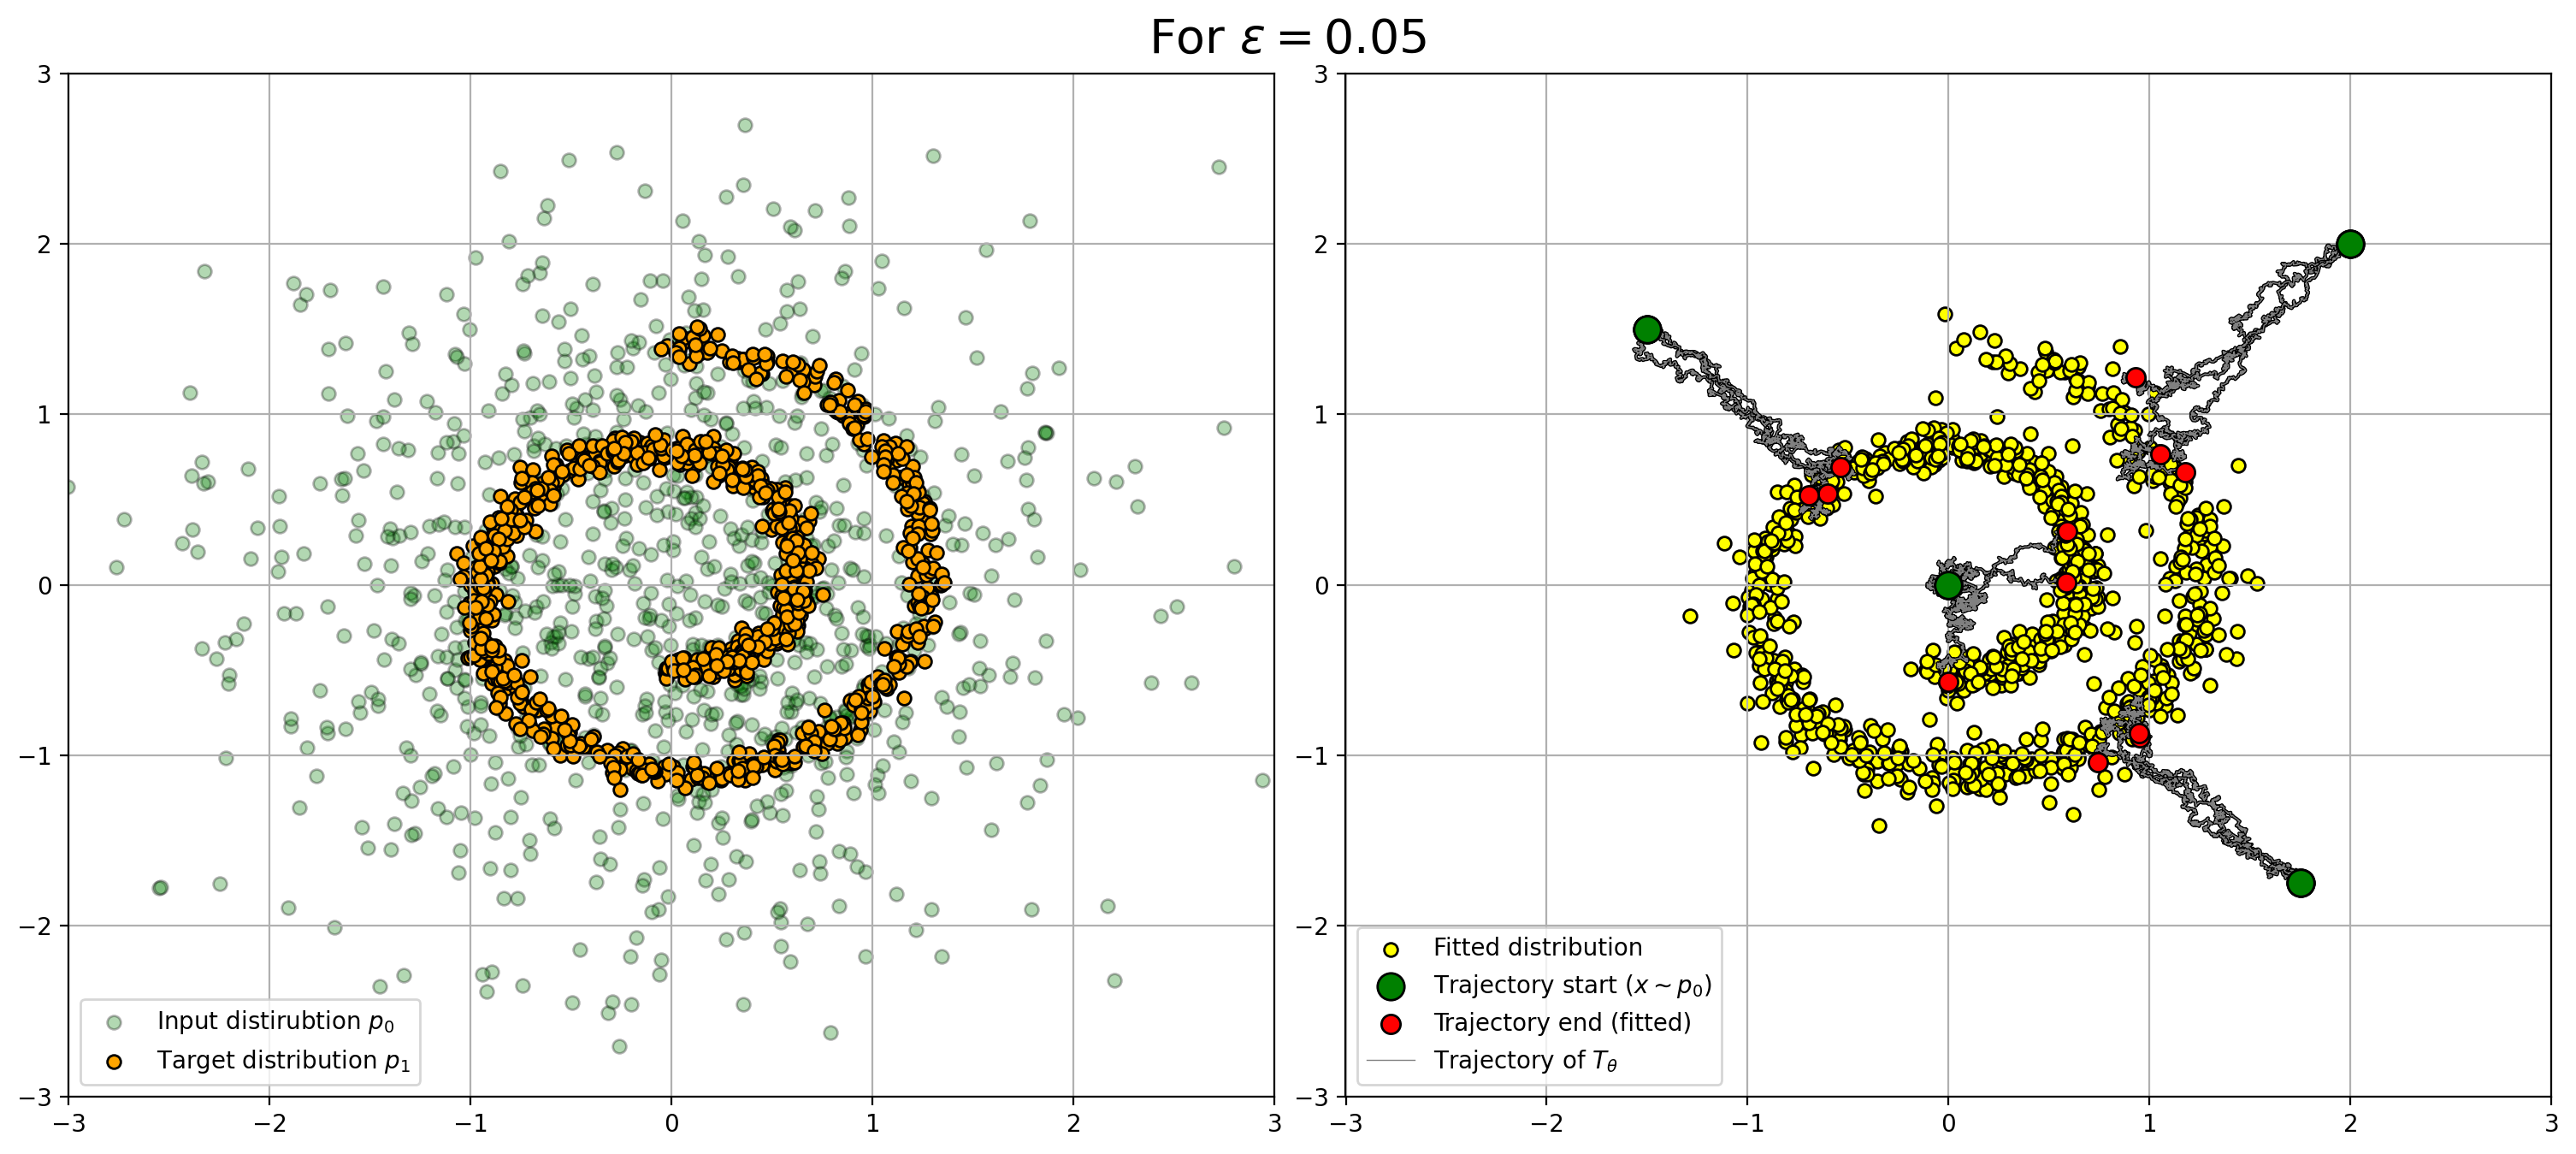

In [6]:
import matplotlib.pyplot as plt

#Define solver
solver = SDE_Solver(steps=STEPS, eps=EPS, device=DEVICE)


fig, axes = plt.subplots(1, 2, figsize=(15, 6.75), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

#====
#Data
x_samples = sample_2d_gaussian(DATA_N)
y_samples= sample_2d_swiss_roll(DATA_N, std=STD)

tr_samples = torch.tensor([[0.0, 0.0], [1.75, -1.75], [-1.5, 1.5], [2, 2]])
tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1

#Use solve method of SDE_Solver to get trajectory and mapped distribution
trajectory, y_pred = solver.solve(x_samples, velocity_net)
trajectory_example, pred_example = solver.solve(tr_samples, velocity_net)


axes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
axes[0].scatter(y_samples[:, 0], y_samples[:, 1], 
                c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")

ax.scatter(y_pred[:, 0], y_pred[:, 1], 
           c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)


ax.scatter(tr_samples[:, 0], tr_samples[:, 1], 
   c="g", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)

ax.scatter(trajectory_example[:, -1, 0], trajectory_example[:, -1, 1], 
   c="red", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)

for i in range(12):
    ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "black", markeredgecolor="black",
         linewidth=1.5, zorder=2)
    if i == 0:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2, label=r"Trajectory of $T_{\theta}$")
    else:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2)

for ax in axes:
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.legend(loc="lower left")

fig.suptitle(fr'For $\epsilon = {EPS}$', fontsize=20)

fig.tight_layout(pad=0.5)


In [ ]:
#torch.save(velocity_net, "../checkpoints/forward_eps_005.model")

### Saved trained nets with different $\epsilon$

In [7]:
#Load pretrained networks
vnet_eps_0 = torch.load("../checkpoints/forward_eps_0.model", weights_only=False)
vnet_eps_1 = torch.load("../checkpoints/forward_eps_1.model", weights_only=False)
vnet_eps_2 = torch.load("../checkpoints/forward_eps_2.model", weights_only=False)
vnet_eps_3 = torch.load("../checkpoints/forward_eps_3.model", weights_only=False)

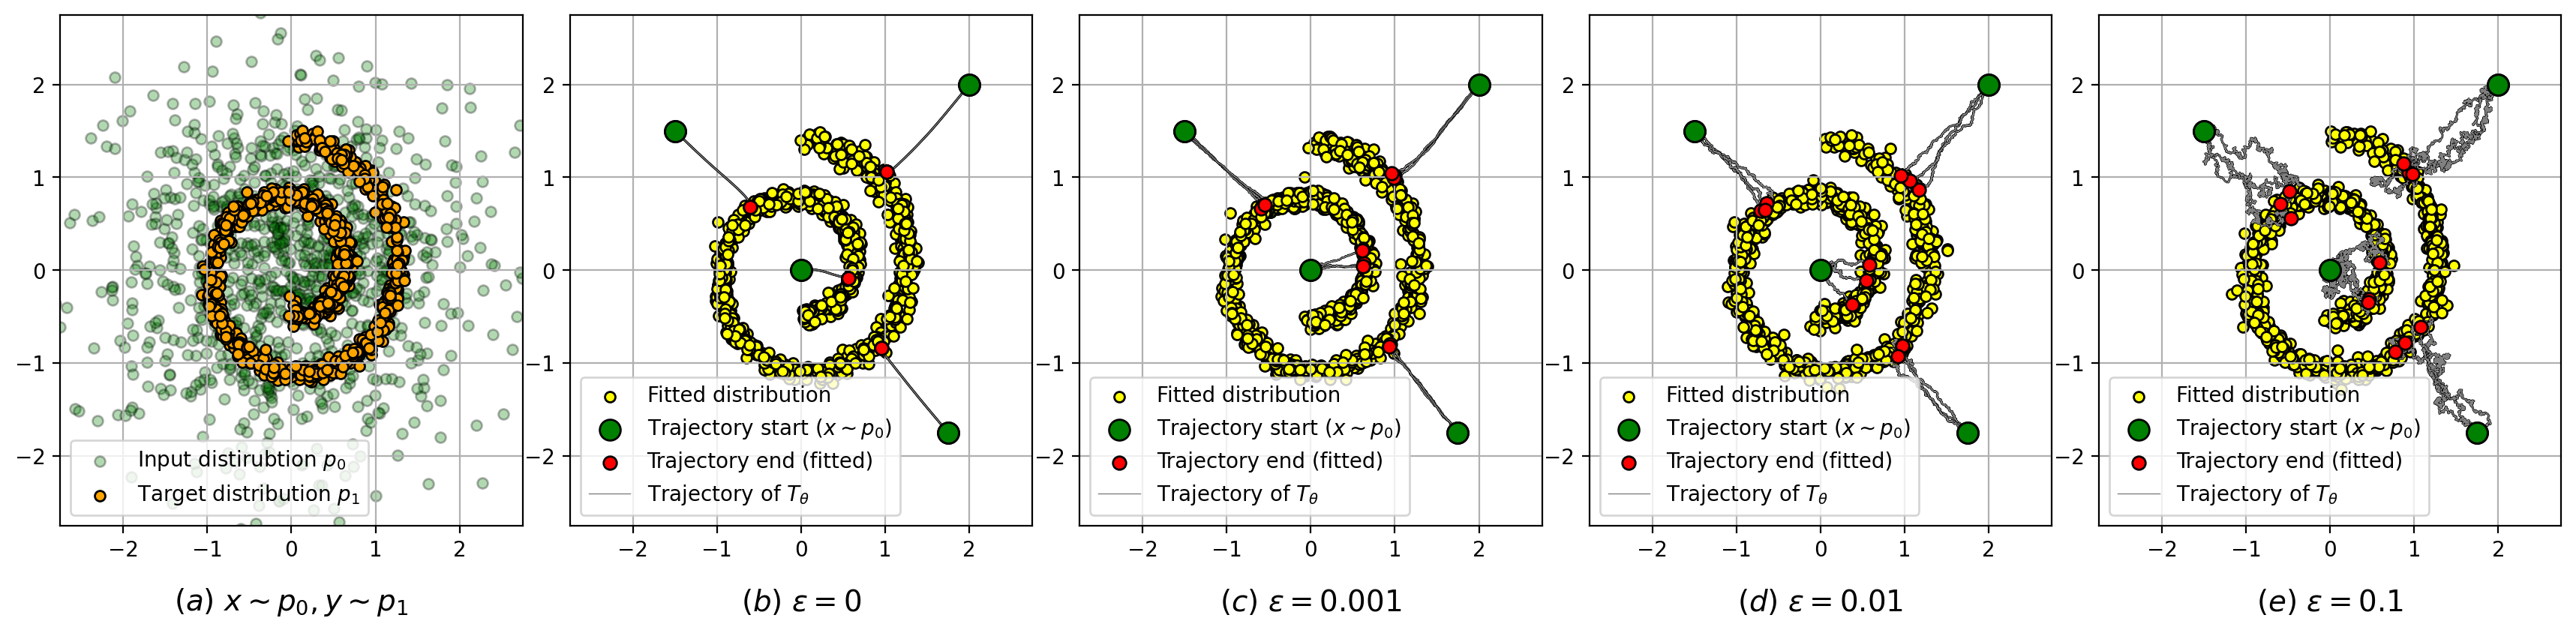

In [19]:
import matplotlib.pyplot as plt

#Define Solvers
solver_eps_0 = SDE_Solver(steps=STEPS, eps=0, device=DEVICE)
solver_eps_1 = SDE_Solver(steps=STEPS, eps=1e-1, device=DEVICE)
solver_eps_2 = SDE_Solver(steps=STEPS, eps=1e-2, device=DEVICE)
solver_eps_3 = SDE_Solver(steps=STEPS, eps=1e-3, device=DEVICE)

fig, axes = plt.subplots(1, 5, figsize=(17, 4), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

x_samples = sample_2d_gaussian(DATA_N)
y_samples = sample_2d_swiss_roll(DATA_N, std=STD)

tr_samples = torch.tensor([[0.0, 0.0], [1.75, -1.75], [-1.5, 1.5], [2, 2]])
tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1

#=====
#Use solve method of SDE_Solver to get trajectory and mapped distribution
#EPS = 0
trajectory_eps_0, y_pred_eps_0 = solver_eps_0.solve(x_samples, vnet_eps_0)
trajectory_example_eps_0, pred_example_eps_0 = solver_eps_0.solve(tr_samples, vnet_eps_0)
#EPS = 1e-1
trajectory_eps_1, y_pred_eps_1 = solver_eps_1.solve(x_samples, vnet_eps_1)
trajectory_example_eps_1, pred_example_1 = solver_eps_1.solve(tr_samples, vnet_eps_1)
#EPS = 1e-2
trajectory_eps_2, y_pred_eps_2 = solver_eps_2.solve(x_samples, vnet_eps_2)
trajectory_example_eps_2, pred_example_eps_2 = solver_eps_2.solve(tr_samples, vnet_eps_2)
#EPS = 1e-3
trajectory_eps_3, y_pred_eps_3 = solver_eps_3.solve(x_samples, vnet_eps_3)
trajectory_example_eps_3, pred_example_eps_3 = solver_eps_3.solve(tr_samples, vnet_eps_3)

#====
#Lists for iterating
y_pred_list = [y_pred_eps_0, y_pred_eps_3, y_pred_eps_2,y_pred_eps_1]
traj_list = [trajectory_example_eps_0, trajectory_example_eps_3, trajectory_example_eps_2, trajectory_example_eps_1]

#=====
#Plotting
for i in range(0,5):
   
    if i == 0:
        axes[i].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                c="g", s=25, edgecolors="black", label = r"Input distirubtion $p_0$")
        axes[i].scatter(y_samples[:, 0], y_samples[:, 1], 
                c="orange", s=25, edgecolors="black", label = r"Target distribution $p_1$")
    else:
       
        axes[i].scatter(y_pred_list[i-1][:, 0], y_pred_list[i-1][:, 1], 
                c="yellow", s=25, edgecolors="black", label = "Fitted distribution", zorder=1)

        axes[i].scatter(tr_samples[:, 0], tr_samples[:, 1], 
                c="g", s=100, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)
        axes[i].scatter(traj_list[i-1][:, -1, 0], traj_list[i-1][:, -1, 1], 
                c="red", s=40, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)
        
        for j in range(12):
            axes[i].plot(traj_list[i-1][j, ::1, 0], traj_list[i-1][j, ::1, 1], "black", markeredgecolor="black",
                linewidth=1, zorder=2)
            if j == 0:
                axes[i].plot(traj_list[i-1][j, ::1, 0], traj_list[i-1][j, ::1, 1], "grey", markeredgecolor="black",
                    linewidth=0.5, zorder=2, label=r"Trajectory of $T_{\theta}$")
            else:
                axes[i].plot(traj_list[i-1][j, ::1, 0], traj_list[i-1][j, ::1, 1], "grey", markeredgecolor="black",
                    linewidth=0.5, zorder=2)

titles = [r"$(a)$ $x \sim p_0, y \sim p_1$", r"$(b)$ $\epsilon = 0$", r"$(c)$ $\epsilon = 0.001$", r"$(d)$ $\epsilon = 0.01$", r"$(e)$ $\epsilon = 0.1$"]

for ax, title in zip (axes, titles):
    ax.set_xlim([-2.75, 2.75])
    ax.set_ylim([-2.75, 2.75])
    ax.legend(loc="lower left")
    
    ax.text(0.5, -0.15, title, ha='center', va='center', transform=ax.transAxes, fontsize=14)

fig.tight_layout(pad=0.1)

## Part 2
1. $V_{\theta}(x,t)$ - "forward" velocity or drift pointing from Normal to Swiss Roll 
2. $V_{\phi}(x,t)$ - "backward" velocity or drift pointing from Swiss Roll to Normal 
3. $t{\epsilon}[0,1]$:  time flows from 0 to 1
##### $Therefore,$ $V_{\xi}(x,t)$ = $\frac{V_{\theta}(x,t) - V_{\phi}(x,t)}{2}$ is a drift for ODE



#### Loading pretrained models and SDE solver with parameter $\epsilon = 0.1$

In [27]:
velocity_forward = torch.load(f"../checkpoints/forward_eps_1.model", weights_only=False )
velocity_backward = torch.load(f"../checkpoints/backward_eps_1.model", weights_only=False)
velocity_eps_0 = torch.load(f"../checkpoints/forward_eps_0.model", weights_only=False)

solver_eps_0 = SDE_Solver(steps=STEPS, eps=0, device=DEVICE)
solver_eps_1 = SDE_Solver(steps=STEPS, eps=0.1, device=DEVICE)

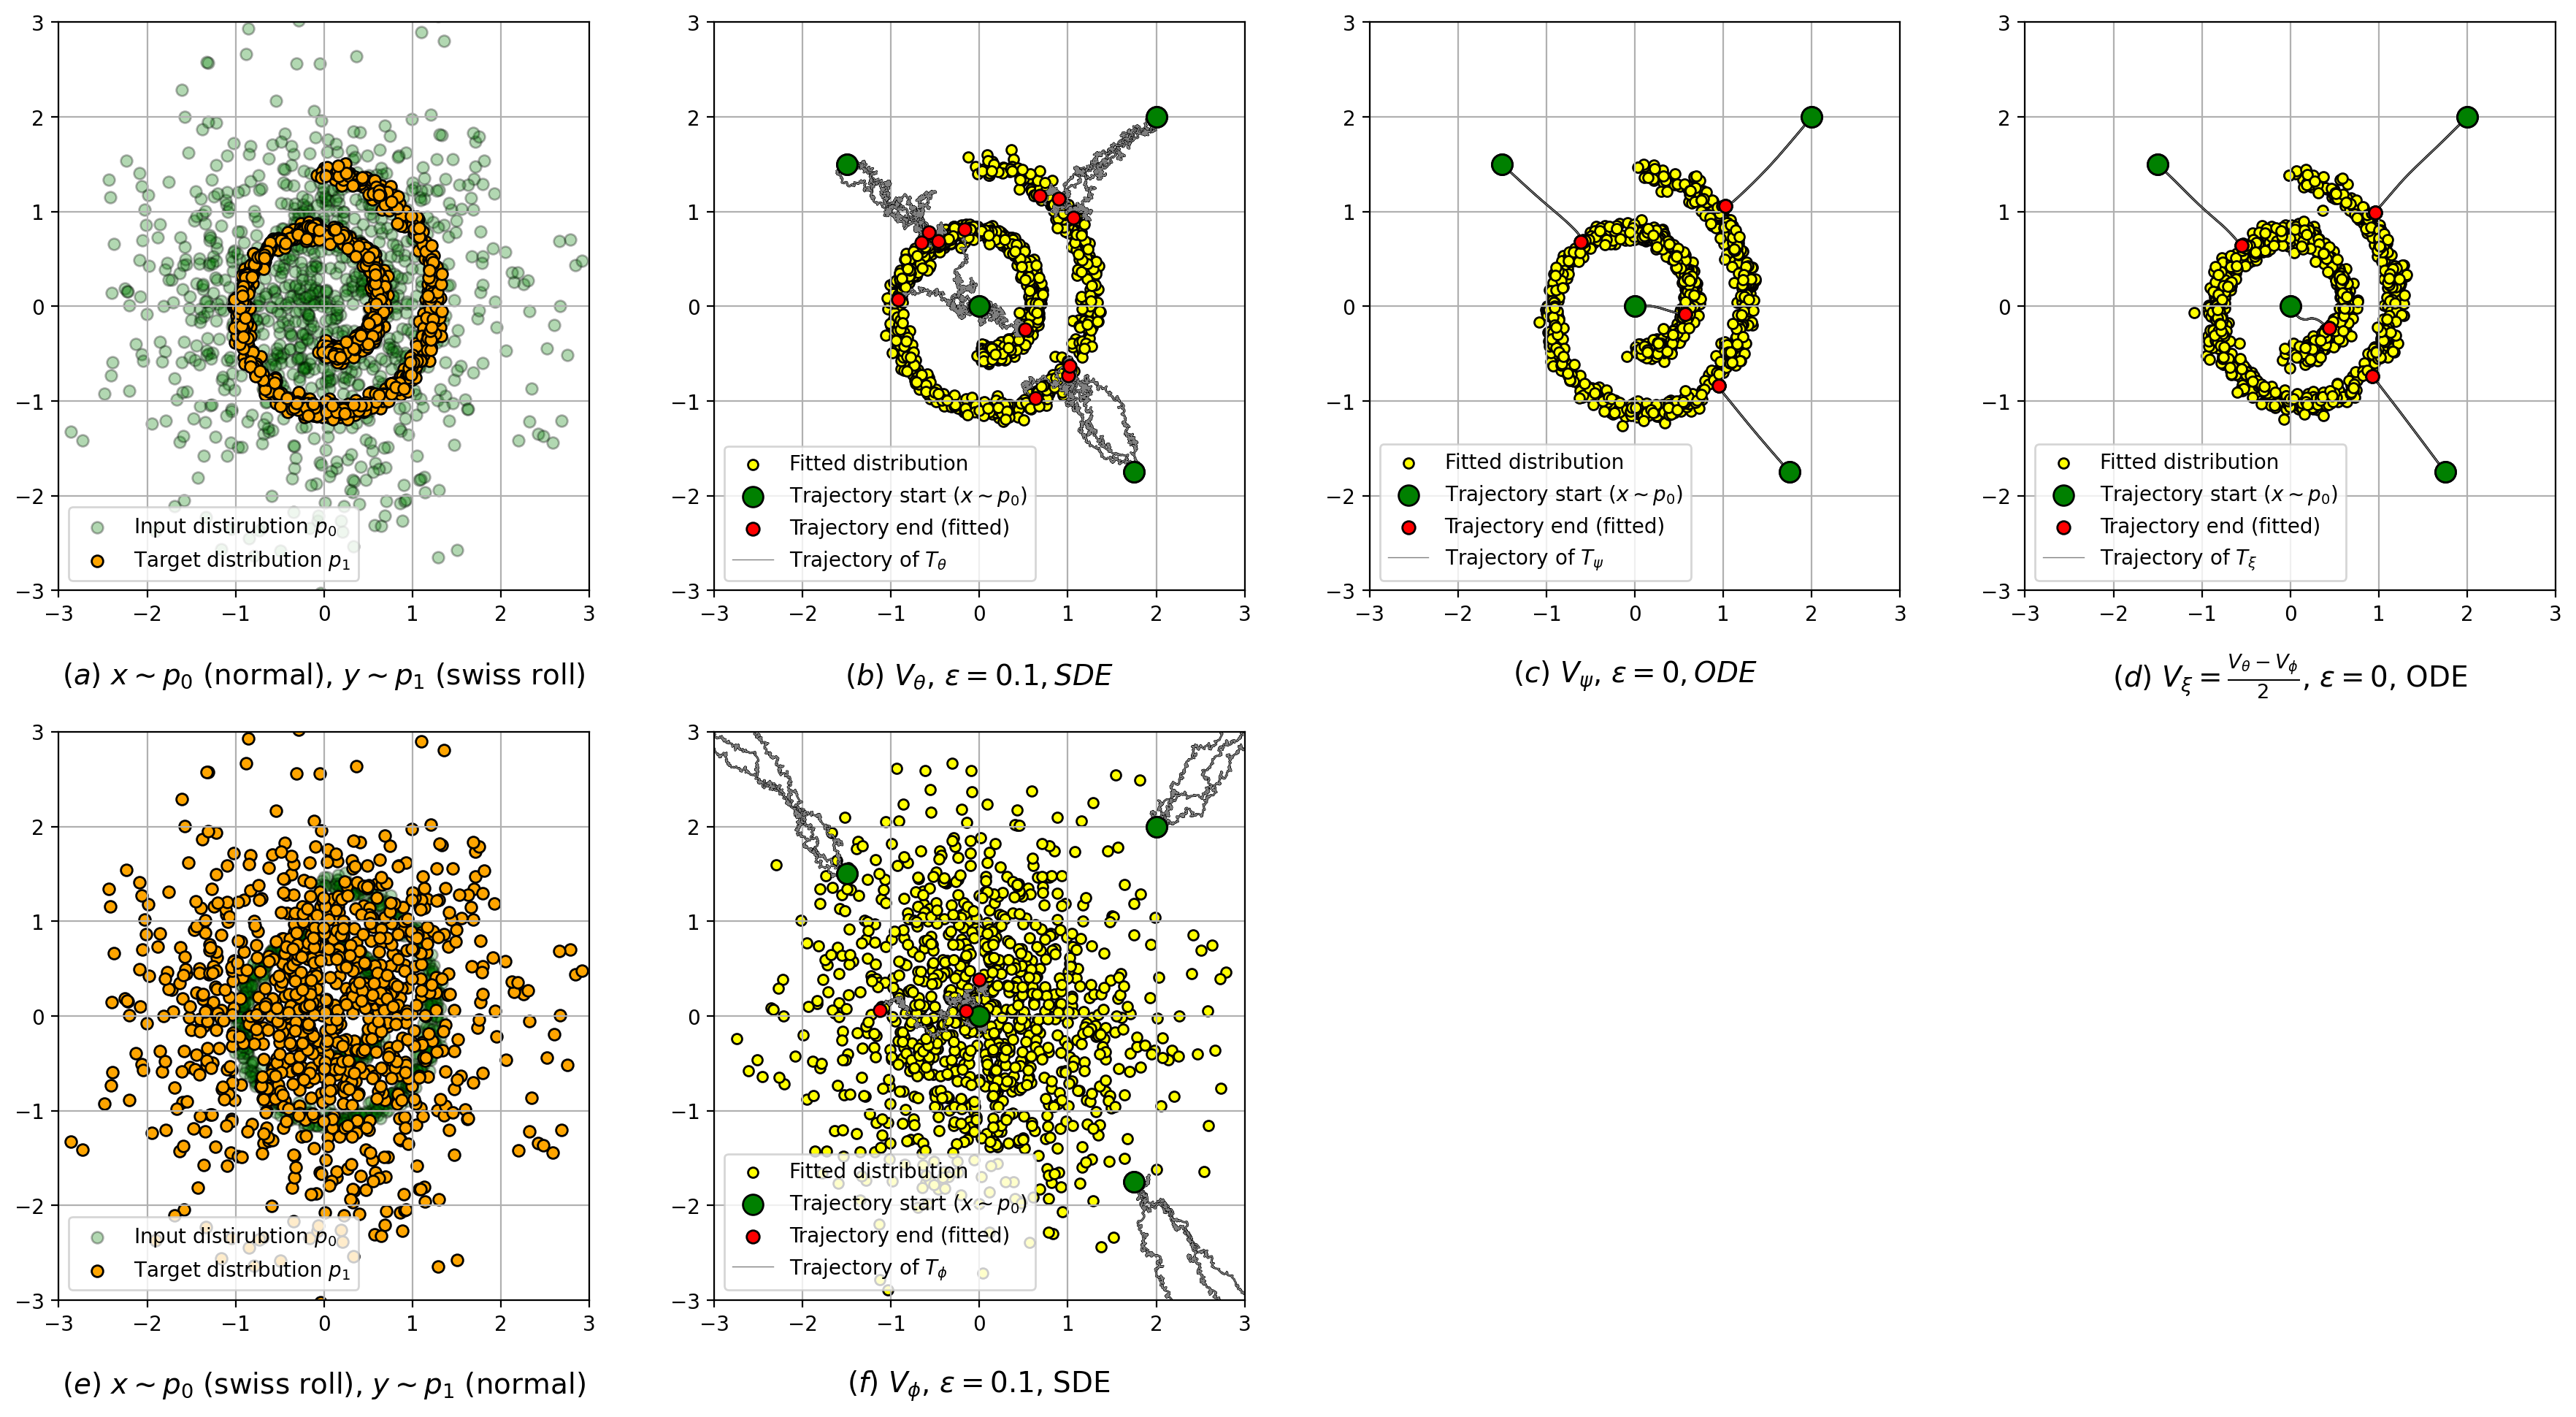

In [58]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(18, 10), dpi=200)

axes = axes.flatten()

for ax in axes:
    ax.grid(zorder=-20)

#=====
#Data from Normal to Swiss roll
x_samples = sample_2d_gaussian(DATA_N) #data to be mapped
y_samples = sample_2d_swiss_roll(DATA_N, std=STD) #target data

tr_samples = torch.tensor([[0.0, 0.0], [1.75, -1.75], [-1.5, 1.5], [2, 2]])
tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)

#=====
#Solve from Normal to Swiss roll, eps 0.1
trajectory_n_to_s, y_pred_n_to_s = solver_eps_1.solve(x_samples, velocity_forward)
trajectory_example_n_to_s, pred_example_n_to_s = solver_eps_1.solve(tr_samples, velocity_forward)
#=====
#Solve from Swiss roll to Normal, eps 0.1
trajectory_s_to_n, y_pred_s_to_n = solver_eps_1.solve(y_samples, velocity_backward)
trajectory_example_s_to_n, pred_example_s_to_n = solver_eps_1.solve(tr_samples, velocity_backward)

#=====
#Solve from Normal to Swiss roll, eps 0
trajectory_n_to_s_0, y_pred_n_to_s_0 = solver_eps_0.solve(x_samples, velocity_eps_0)
trajectory_example_n_to_s_0, pred_example_n_to_s_0 = solver_eps_0.solve(tr_samples, velocity_eps_0)

#=====
#Experimental velocity/drift, eps 0
trajectory_exp, y_pred_exp = solver_eps_0.solve(x_samples,velocity_forward, velocity_backward)
trajectory_example_exp, pred_example_exp = solver_eps_0.solve(tr_samples, velocity_forward, velocity_backward)

#=====
#Lists for iterations
y_pred_list_2 = [None, y_pred_n_to_s, y_pred_n_to_s_0, y_pred_exp, None, y_pred_s_to_n]
traj_list_2 = [None, trajectory_example_n_to_s, trajectory_example_n_to_s_0, trajectory_example_exp, None, trajectory_example_s_to_n]
label_t = [None, r"Trajectory of $T_{\theta}$",r"Trajectory of $T_{\psi}$", r"Trajectory of $T_{\xi}$", None, r"Trajectory of $T_{\phi}$"]

for i in range(0,6):
    if i == 0:
        axes[i].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                        c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
        axes[i].scatter(y_samples[:, 0], y_samples[:, 1], 
                        c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")
    elif i == 4:
        axes[i].scatter(y_samples[:, 0], y_samples[:, 1], alpha=0.3, 
                        c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
        axes[i].scatter(x_samples[:, 0], x_samples[:, 1], 
                        c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")
    else:
        axes[i].scatter(y_pred_list_2[i][:, 0], y_pred_list_2[i][:, 1], 
                c="yellow", s=25, edgecolors="black", label = "Fitted distribution", zorder=1)

        axes[i].scatter(tr_samples[:, 0], tr_samples[:, 1], 
                c="g", s=100, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)
        axes[i].scatter(traj_list_2[i][:, -1, 0], traj_list_2[i][:, -1, 1], 
                c="red", s=40, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)
        
        for j in range(12):
            axes[i].plot(traj_list_2[i][j, ::1, 0], traj_list_2[i][j, ::1, 1], "black", markeredgecolor="black",
                linewidth=1, zorder=2)
            if j == 0:
                axes[i].plot(traj_list_2[i][j, ::1, 0], traj_list_2[i][j, ::1, 1], "grey", markeredgecolor="black",
                    linewidth=0.5, zorder=2, label=label_t[i])
            else:
                axes[i].plot(traj_list_2[i][j, ::1, 0], traj_list_2[i][j, ::1, 1], "grey", markeredgecolor="black",
                    linewidth=0.5, zorder=2)        

# Remove the seventh subplot
axes[6].axis('off')
# Remove the eighth subplot
axes[7].axis('off')

titles = [r"$(a)$ $x \sim p_0$ (normal), $y \sim p_1$ (swiss roll)",
            r"$(b)$ $V_\theta$, $\epsilon = 0.1, SDE$",
            r"$(c)$ $V_\psi$, $\epsilon = 0, ODE$",
            r"$(d)$ $V_\xi = \frac{V_\theta - V_\phi}{2}$, $\epsilon = 0$, ODE",
            r"$(e)$ $x \sim p_0$ (swiss roll), $y \sim p_1$ (normal)",
            r"$(f)$ $V_\phi$, $\epsilon = 0.1$, SDE "]

for ax, title in zip (axes, titles):
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.legend(loc="lower left")
    ax.text(0.5, -0.15, title, ha='center', va='center', transform=ax.transAxes, fontsize=14)

#fig.suptitle(r'For $\epsilon = 0.1$', fontsize=20)

fig.tight_layout(pad=2)